## EXPLORATORY PROJECT
Machine Learning Holography for 3D Particle Field Imaging 

Pushker Naresh
 19174018

This Notebook is for 3D holograms with target intensity specified on a rectangular grid (512x512x3 pixels). Here we use extensively trained models for 512x512x3 and 1024x1024x3.

**Step 1** - We import the necessary modules and we clone the Github repository into the working directory of this google colab session. 

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time
!git clone https://github.com/Pushker-stark/DeepCGH.git
os.chdir('DeepCGH')

Cloning into 'DeepCGH'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 167 (delta 6), reused 9 (delta 2), pack-reused 149
Receiving objects: 100% (167/167), 111.37 MiB | 22.56 MiB/s, done.
Resolving deltas: 100% (92/92), done.
Checking out files: 100% (18/18), done.


Now we can use `deepcgh.DeepCGH_Datasets` to generate the dataset and train a model with it.

`DeepCGH_Datasets`: is a module that synthesizes training data set.

`DeepCGH`: is the main module that contains the pre-trained model and performs the training.

In [ ]:
from deepcgh import DeepCGH_Datasets, DeepCGH
from utils import GS3D, display_results, get_propagate

We specify the properties of the training dataset that will be used to train the DeepCGH model. Here we only create a small dataset (N=100) since creating and storing a large dataset is time-consuming.

In [ ]:
retrain = True
coordinates = False

data = {'path' : 'DeepCGH_Datasets/Disks',# path to store the data
        'shape' : (512, 512, 3),# shape of the holograms. The last dimension determines the number of depth planes
        'object_type' : 'Disk',# shape of the object in simulated images, can be disk, square, or line
        'object_size' : 10,# has no effect if object type is 'Line'
        'object_count' : [27, 48],# number of random objects to be created
        'intensity' : [0.2, 1],# the (range of) intensity of each object. If a range is specified, for each object the intensity is randomly determined
        'normalize' : True,# if the data is 3D, it'll normalize the intensities from plane to plane (see manuscript fot more info)
        'centralized' : False,# avoids putting objects near the edges of the hologram (useful for practical optogenetics applications)
        'N' : 100, # number of sample holograms to generate
        'train_ratio' : 90/100,# the ratio of N that will be used for training
        'compression' : 'GZIP',# tfrecords compression format
        'name' : 'target',# name of the dictionary that contains the targets (leave as "target" if you're not changing the structure of network input)
        }

We generate the dataset by calling the `getDataset` method:

In [ ]:
dset = DeepCGH_Datasets(data)
dset.getDataset()

/content/DeepCGH/deepcgh.py:72: UserWarning: File does not exist. New dataset will be generated once getDataset is called.
  warnings.warn('File does not exist. New dataset will be generated once getDataset is called.')
  1%|          | 1/100 [00:00<00:13,  7.16it/s]

Current working directory is:
/content/DeepCGH/DeepCGH 

/content/DeepCGH/DeepCGH/DeepCGH_Datasets/Disks/Disk_SHP(512, 512, 3)_N100_SZ10_INT[0.2, 1]_Crowd[27, 48]_CNTFalse_Split.tfrecords
Generating data...


100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Here we define the model parameters:

In [ ]:
model = {'path' : 'DeepCGH_Models/Disks',# the path to the saved model
        'plane_distance':0.005,# the physical distance between depth planes when we're doing 3D holography
         # physical setup parameters
        'wavelength':1e-6,# the wavelength of the laser (both simulations and experiments)
        'pixel_size':0.000015,# size of the SLM pixel sizes
        'int_factor':16,# the interleaving factor
         # CNN model and training parameters
        'n_kernels':[ 64, 128, 256],# the number of kernels in the U-Net model (see the manuscript)
        'input_name':'target',# name of the input layer in the U-Net model
        'output_name':'phi_slm',# name of the output layer
        'lr' : 1e-7,# learning rate of the optimizer
        'batch_size' : 8,
        'epochs' : 1,
        'shuffle' : 8,# determine how many samples are going to be shuffled
        'token' : '64',# string to be attached to the name of the model to differentiate it from similar models
        'max_steps' : 5000 # maxmimum number of batches/steps to be processed
        }


**Step 2** - We create the DeepCGH module and train it. The code includes extensively trained models for 512x512x3 and 1024x1024x3. For those models, training will begin from the pretrained model and run for one more epoch on the dataset we just generated. In other case,we have to train the model that takes time as it will begin from scratch.

In [ ]:
dcgh = DeepCGH(data, model)

Looking for trained models in:
/content/DeepCGH/DeepCGH 

Model already exists.


Now we train/load the model by calling the `train` method:

In [ ]:
dcgh.train(dset)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/content/DeepCGH/DeepCGH/DeepCGH_Models/Disks/Model_Disk_SHP(512, 512, 3)_IF16_Dst0.005_WL1e-06_PS1.5e-05_CNTFalse_64', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_w

**Step 3** - Once the model is trained/loaded, we can start inference. We generate a random sample:

In [ ]:
image = dset.get_randSample()[np.newaxis,...]
# making inference is as simple as calling the get_hologram method
phase = dcgh.get_hologram(np.zeros_like(image)) # the very first inference takes a long time (a known tensorflow characteristic)

We compute the phase and measure the inference time:

In [ ]:
t0 = time()
phase = dcgh.get_hologram(image)
t = time() - t0

Now we simulate the hologram that this phase will generate:

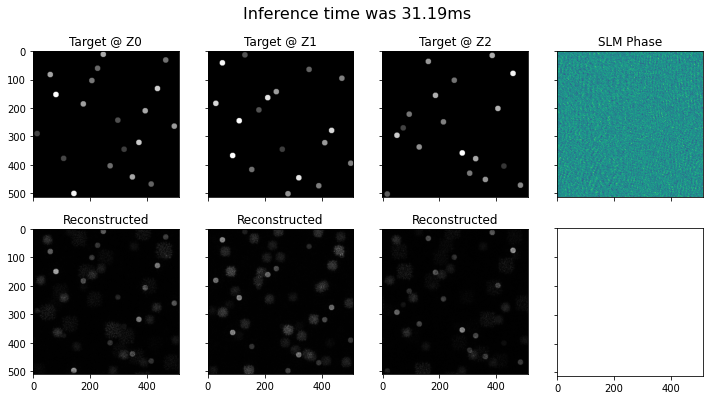

In [ ]:
propagate = get_propagate(data, model)
reconstruction = propagate(phase)
display_results(image, phase, reconstruction, t)


The results from our simulations on 1000 3D test samples using a Titan RTX GPU shows DeepCGH can generate 3D holograms at a significantly better accuracy than any other technique and does so at record speeds.